## 데이터셋 구성
- train, validation

In [1]:
import numpy as np
import tqdm
import os
import pickle
from matplotlib import pyplot as plt

train_x = []
train_y = []
eval_x = []
eval_y = []

train_path = '/home/aiffel0049/aiffel/Exploration/13.tensorflow.js/data/train.pkl'
eval_path = '/home/aiffel0049/aiffel/Exploration/13.tensorflow.js/data/eval.pkl'
if os.path.exists(train_path):
    train_x, train_y = pickle.load(open(train_path, 'rb'))
    eval_x, eval_y = pickle.load(open(eval_path, 'rb'))
else:
    csv_path = '/home/aiffel0049/aiffel/Exploration/13.tensorflow.js/data/fer2013.csv'

    with open(csv_path) as f:
        for line in tqdm.tqdm(f.read().splitlines()[1:]):
            emotion, pixels, usage = line.split(',')

            x = np.array(pixels.split()).astype(float).reshape(48, 48, 1) / 255
            y = int(emotion)

            if usage == 'PrivateTest':
                eval_x.append(x)
                eval_y.append(y)
            else:
                train_x.append(x)
                train_y.append(y)

    pickle.dump([train_x, train_y], open(train_path, 'wb'))
    pickle.dump([eval_x, eval_y], open(eval_path, 'wb'))

print('train : {}, eval : {}'.format(len(train_x), len(eval_x)))


train : 32298, eval : 3589


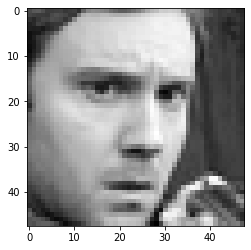

In [2]:
from matplotlib import pyplot as plt

plt.imshow(train_x[0].reshape([48,48]), cmap='gray')

In [2]:
LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neural']

train_x, train_y = np.array(train_x), np.array(train_y)
print(train_x.shape, train_y.shape)

(32298, 48, 48, 1) (32298,)


In [3]:
def cal_label_count(dataset):
    label_count_dataset = [0] * len(LABELS)
    for data in dataset:
        label_count_dataset[data] += 1
    label_count_dataset = np.array(label_count_dataset)
    dataset_size = label_count_dataset.sum()
    print(label_count_dataset, label_count_dataset / dataset_size, dataset_size)

cal_label_count(train_y)
cal_label_count(eval_y)

[4462  492 4593 8110 5483 3586 5572] [0.13815097 0.01523314 0.14220695 0.25109914 0.16976283 0.11102855
 0.17251842] 32298
[491  55 528 879 594 416 626] [0.13680691 0.0153246  0.14711619 0.24491502 0.16550571 0.11590972
 0.17442184] 3589


## 데이터 전처리

- 오버샘플링
    https://www.tensorflow.org/tutorials/structured_data/imbalanced_data   
    상대적으로 개수가 적은 1, 5번 (Disgust, Surprise)의 데이터를 오버샘플링 진행
- 언더샘플링
    제일 개수가 적은 1번에 맞춰 언더샘플링 진행

In [5]:
def oversampling(train_x, train_y):
    do_five = False
    pos_train_y_1 = train_y == 1
    pos_x_1 = train_x[pos_train_y_1]
    pos_y_1 = train_y[pos_train_y_1]
    if do_five:
        pos_train_y_5 = train_y == 5
        pos_x_5 = train_x[pos_train_y_5]
        pos_y_5 = train_y[pos_train_y_5]

    if not do_five:
        neg_x = train_x[~pos_train_y_1]
        neg_y = train_y[~pos_train_y_1]
    else:
        neg_x = train_x[~(pos_train_y_1 | pos_train_y_5)]
        neg_y = train_y[~(pos_train_y_1 | pos_train_y_5)]

    ids_1 = np.arange(len(pos_x_1))
    choices_1 = np.random.choice(ids_1, len(neg_x) // 5)

    res_pos_x_1 = pos_x_1[choices_1]
    res_pos_y_1 = pos_y_1[choices_1]
    print(res_pos_x_1.shape)
    
    if do_five:
        ids_5 = np.arange(len(pos_x_5))
        choices_5 = np.random.choice(ids_5, len(neg_x) // 5)

        res_pos_x_5 = pos_x_5[choices_5]
        res_pos_y_5 = pos_y_5[choices_5]
        print(res_pos_x_5.shape)
    
    if not do_five:
        resampled_x = np.concatenate([res_pos_x_1, neg_x], axis=0)
        resampled_y = np.concatenate([res_pos_y_1, neg_y], axis=0)
    else:
        resampled_x = np.concatenate([res_pos_x_1, res_pos_x_5, neg_x], axis=0)
        resampled_y = np.concatenate([res_pos_y_1, res_pos_y_5, neg_y], axis=0)

    return resampled_x, resampled_y

In [6]:
def undersampling(train_x, train_y, index):
    pos_train_y = list()
    for i in range(len(LABELS)):
        if i != index:
            pos_train_y.append(train_y != i)
    
    pos_x = list()
    pos_y = list()
    for condition in pos_train_y:
        pos_x.append(train_x[condition])
        pos_y.append(train_y[condition])
    neg_x = train_x[train_y == index]
    neg_y = train_y[train_y == index]

    res_pos_x = list()
    res_pos_y = list()
    for pos_x_elem, pos_y_elem in zip(pos_x, pos_y):
        ids = np.arange(len(pos_x_elem))
        choices = np.random.choice(ids, len(neg_x))
        res_pos_x.append(pos_x_elem[choices])
        res_pos_y.append(pos_y_elem[choices])

        print(res_pos_x[-1].shape)
        print(res_pos_y[-1].shape)

    resampled_x = np.concatenate(res_pos_x + [neg_x], axis=0)
    resampled_y = np.concatenate(res_pos_y + [neg_y], axis=0)
    return resampled_x, resampled_y

In [7]:
do_resampling = False
if do_resampling:
    resampled_x, resampled_y = oversampling(train_x, train_y)
    # resampled_x, resampled_y = undersampling(train_x, train_y, 1)

    order = np.arange(len(resampled_y))
    np.random.shuffle(order)
    resampled_x = resampled_x[order]
    resampled_y = resampled_y[order]
    print(resampled_x.shape)
    print(resampled_y.shape)
    cal_label_count(resampled_y)

In [9]:
import tensorflow as tf
if do_resampling:
    resampled_x, resampled_y = np.array(resampled_x), tf.keras.utils.to_categorical(resampled_y)
else:
    resampled_x, resampled_y = np.array(train_x), tf.keras.utils.to_categorical(train_y)
res_eval_x, res_eval_y = np.array(eval_x), tf.keras.utils.to_categorical(eval_y)
print(resampled_x.shape, resampled_y.shape)
print(res_eval_x.shape, res_eval_y.shape)

(32298, 48, 48, 1) (32298, 7)
(3589, 48, 48, 1) (3589, 7)


- Google Facial Expression   
    https://research.google/tools/datasets/google-facial-expression/   
    https://www.kaggle.com/ahmedmoorsy/facial-expression   

## MobileNet 모델 학습

In [10]:
from tensorflow.python.client import device_lib
# print(tf.config.list_physical_devices('GPU'))
# print(tf.config.list_physical_devices('XLA_GPU'))
print(device_lib.list_local_devices())
print(tf.test.gpu_device_name())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 703102667438494414
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12526333873548974793
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16235997329239488307
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6924641248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 320241239528179280
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
/device:GPU:0


- mobilenetv2   
    https://keras.io/api/applications/mobilenet/#mobilenetv2-function
- adam   
    https://keras.io/ko/optimizers/#adam
- loss   
    https://keras.io/ko/losses/
- categorical_crossentropy vs sparse_categorical_crossentropy   
    https://crazyj.tistory.com/
    
        categorical : 클래스 = one-hot encoding
        sparse_categorical : 클래스 = integer

- one-hot encoding   
    https://wikidocs.net/22647   
    https://keras.io/ko/utils/#to_categorical
- callbacks   
    ReduceLRonPlateau : https://keras.io/ko/callbacks/#reducelronplateau
    

In [22]:
# model 선언 
model = tf.keras.applications.MobileNetV2(
    input_shape=(48,48,1),
    weights=None,
    classes=len(LABELS)
)

# model.compile
lr = 1e-3
# decay = 1e-4
optimizer = tf.keras.optimizers.Adam(lr=lr)
# optimizer = tf.keras.optimizers.Adam(lr=lr, decay=decay)

loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy()
# loss = tf.keras.losses.SparseCategoricalCrossentropy()
# metrics = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

# model callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                                 factor=0.2, patience=10)
experiment_num = 8
model_dir = '/home/aiffel0049/aiffel/Exploration/13.tensorflow.js/model/'
model_path = 'model_{epoch:02d}_{val_categorical_accuracy:.6f}.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_dir + model_path, monitor='val_categorical_accuracy',
                                                verbose=1, save_best_only=True, mode='max')
# model.fit
epochs=100
history = model.fit(resampled_x,
                    resampled_y,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(res_eval_x, res_eval_y),
                    callbacks=[checkpoint])

Epoch 1/100
63/64 [============================>.] - ETA: 0s - loss: 1.8363 - categorical_accuracy: 0.2391
Epoch 00001: val_categorical_accuracy improved from -inf to 0.24492, saving model to /home/aiffel0049/aiffel/Exploration/13.tensorflow.js/model/model_01_0.244915.h5
64/64 [==============================] - 8s 124ms/step - loss: 1.8363 - categorical_accuracy: 0.2391 - val_loss: 1.9362 - val_categorical_accuracy: 0.2449
Epoch 2/100
63/64 [============================>.] - ETA: 0s - loss: 1.7056 - categorical_accuracy: 0.3076
Epoch 00002: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 109ms/step - loss: 1.7057 - categorical_accuracy: 0.3075 - val_loss: 1.9332 - val_categorical_accuracy: 0.1744
Epoch 3/100
63/64 [============================>.] - ETA: 0s - loss: 1.5892 - categorical_accuracy: 0.3752
Epoch 00003: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 110ms/step - loss: 1.5893 

Epoch 26/100
63/64 [============================>.] - ETA: 0s - loss: 0.4408 - categorical_accuracy: 0.8427
Epoch 00026: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 113ms/step - loss: 0.4411 - categorical_accuracy: 0.8426 - val_loss: 2.1673 - val_categorical_accuracy: 0.1655
Epoch 27/100
63/64 [============================>.] - ETA: 0s - loss: 0.3639 - categorical_accuracy: 0.8697
Epoch 00027: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 112ms/step - loss: 0.3642 - categorical_accuracy: 0.8696 - val_loss: 2.1984 - val_categorical_accuracy: 0.1655
Epoch 28/100
63/64 [============================>.] - ETA: 0s - loss: 0.4172 - categorical_accuracy: 0.8529
Epoch 00028: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 112ms/step - loss: 0.4175 - categorical_accuracy: 0.8529 - val_loss: 2.1844 - val_categorical_accuracy: 0.1655
Epoch 29/1

Epoch 51/100
63/64 [============================>.] - ETA: 0s - loss: 0.1930 - categorical_accuracy: 0.9333
Epoch 00051: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 111ms/step - loss: 0.1930 - categorical_accuracy: 0.9333 - val_loss: 2.5460 - val_categorical_accuracy: 0.1655
Epoch 52/100
63/64 [============================>.] - ETA: 0s - loss: 0.1089 - categorical_accuracy: 0.9630
Epoch 00052: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 111ms/step - loss: 0.1090 - categorical_accuracy: 0.9630 - val_loss: 2.5884 - val_categorical_accuracy: 0.1655
Epoch 53/100
63/64 [============================>.] - ETA: 0s - loss: 0.1435 - categorical_accuracy: 0.9512
Epoch 00053: val_categorical_accuracy did not improve from 0.24492
64/64 [==============================] - 7s 111ms/step - loss: 0.1437 - categorical_accuracy: 0.9511 - val_loss: 2.6248 - val_categorical_accuracy: 0.1655
Epoch 54/1

Epoch 76/100
63/64 [============================>.] - ETA: 0s - loss: 0.0754 - categorical_accuracy: 0.9754
Epoch 00076: val_categorical_accuracy did not improve from 0.28587
64/64 [==============================] - 7s 111ms/step - loss: 0.0756 - categorical_accuracy: 0.9753 - val_loss: 3.4017 - val_categorical_accuracy: 0.2572
Epoch 77/100
63/64 [============================>.] - ETA: 0s - loss: 0.1203 - categorical_accuracy: 0.9590
Epoch 00077: val_categorical_accuracy improved from 0.28587 to 0.30872, saving model to /home/aiffel0049/aiffel/Exploration/13.tensorflow.js/model/model_77_0.308721.h5
64/64 [==============================] - 7s 116ms/step - loss: 0.1202 - categorical_accuracy: 0.9590 - val_loss: 3.3116 - val_categorical_accuracy: 0.3087
Epoch 78/100
63/64 [============================>.] - ETA: 0s - loss: 0.0713 - categorical_accuracy: 0.9762
Epoch 00078: val_categorical_accuracy improved from 0.30872 to 0.31095, saving model to /home/aiffel0049/aiffel/Exploration/13.tens

Epoch 97/100
63/64 [============================>.] - ETA: 0s - loss: 0.0795 - categorical_accuracy: 0.9719
Epoch 00097: val_categorical_accuracy did not improve from 0.45612
64/64 [==============================] - 7s 112ms/step - loss: 0.0796 - categorical_accuracy: 0.9718 - val_loss: 5.0033 - val_categorical_accuracy: 0.4517
Epoch 98/100
63/64 [============================>.] - ETA: 0s - loss: 0.1339 - categorical_accuracy: 0.9533
Epoch 00098: val_categorical_accuracy did not improve from 0.45612
64/64 [==============================] - 7s 112ms/step - loss: 0.1342 - categorical_accuracy: 0.9532 - val_loss: 5.4938 - val_categorical_accuracy: 0.4427
Epoch 99/100
63/64 [============================>.] - ETA: 0s - loss: 0.1444 - categorical_accuracy: 0.9513
Epoch 00099: val_categorical_accuracy did not improve from 0.45612
64/64 [==============================] - 7s 113ms/step - loss: 0.1443 - categorical_accuracy: 0.9513 - val_loss: 5.1498 - val_categorical_accuracy: 0.4377
Epoch 100/

In [23]:
history = history.history
print(history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


- different scale graph   
    https://matplotlib.org/gallery/api/two_scales.html

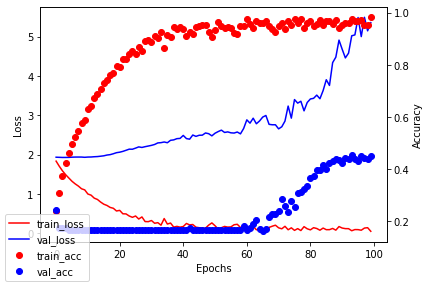

In [24]:
acc_h = history['categorical_accuracy']
loss_h = history['loss']
val_acc_h = history['val_categorical_accuracy']
val_loss_h = history['val_loss']

fig, ax1 = plt.subplots()

ax1.plot(loss_h, 'r', label='train_loss')
ax1.plot(val_loss_h, 'b', label='val_loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()

ax2.plot(acc_h, 'ro', label='train_acc')
ax2.plot(val_acc_h, 'bo', label='val_acc')
ax2.set_ylabel('Accuracy')

fig.tight_layout()
fig.legend(loc='lower left')
plt.show()

img_path = '/home/aiffel0049/aiffel/Exploration/13.tensorflow.js/img/fig_{}.png'.format(experiment_num)
if not os.path.exists(img_path):
    fig.savefig(img_path)

In [25]:
import os
val_acc_final = str(max(val_acc_h))[:8]
print(epochs, val_acc_final)

100 0.456115


## 실험 내용

### 개선방안
- 이미지 중 감정에 해당안되는 데이터 존재 : 얼굴데이터에 해당하는 부분만 추출하여 수행
- data 전처리 : 오버샘플링필요
- val_acc가 epoch=65~70부터 상승 : lr 조절

### 개선방향

1. 기본설정
    - mobilenetv2
    - val_acc = 0.438005

2. 오버샘플링(1, 5) + LR 감쇠
    - oversampling(class=1, 5)
    - LR 감쇠(factor=0.2, patience=10)
    - val_acc = 0.374756
    
3. 오버샘플링(1, 5)
    - oversampling(class=1, 5)
    - val_acc = 0.295068

4. 언더샘플링(1)
    - undersampling(class=1에 맞춤)
    - val_acc = 0.244915
    - 학습이 잘 안됨

5. 오버샘플링(1)
    - oversampling(class=1)
    - val_acc = 0.308442

6. 오버샘플링(1), weight decay
    - oversampling(class=1)
    - weight decay=1e-4
    - val_acc = 0.432711

7. weight decay
    - weight decay=1e-4
    - val_acc = 0.447757

8. modelcheck
    - modelcheck
    - val_acc = 0.456115

## 웹 앱 주소

https://sung0471.github.io/aiffel_13.tensorflow.js/index_project